In [1]:
import pandas as pd


df = pd.read_csv("/data/rsna-breast-cancer-detection/train.csv")

In [2]:
patient_ids = list(df.get('patient_id'))
lateralities = list(df.get('laterality'))
cancers = list(df.get('cancer'))
image_ids = list(df.get('image_id'))


In [3]:
dataset = {}
for patient_id, laterality, cancer, image_id in zip(patient_ids, lateralities, cancers, image_ids):
    key = f"{patient_id}_{laterality}"
    try:
        dataset[key].append([image_id, cancer])
    except KeyError:
        dataset[key] = [[image_id, cancer]]



In [4]:

# No patient has less than 2 mammographies each
for patient_id, values in dataset.items():
    if len(values) < 2:
        print(patient_id)

In [5]:
# Calculate how many images there are for each {patient_id}_{laterality}

max = 0
min = 100

for patient_id, cancers in dataset.items():
    if 'L' in patient_id:
        if len(cancers) > max:
            max = len(cancers)
        if len(cancers) < min:
            min = len(cancers)
print(min, max)

2 7


In [6]:
# Find out if, given a patient and her laterality, the mammograhies have different classes
import numpy as np

print(f"Test {[1, 1, 1, 1]}: all negatives? {not np.array([1, 1, 1, 1]).any()}")
print(f"Test {[0, 0, 0, 0]}: all positives: {np.array([0, 0, 0, 0]).all()}")

found = False
for patient_id, cancers in dataset.items():
    image_ids, cancers_ids = list(zip(*list(cancers)))
    cancers_ids = np.array(cancers_ids)
    # All ones or all zeros: it's the negative of the obvious formula.
    if cancers_ids.any() and not cancers_ids.all():
        print(cancers_ids)
        found = True
        break 
if not found:
    print("Every patient_id has the same class among all mammographies!")
        

Test [1, 1, 1, 1]: all negatives? False
Test [0, 0, 0, 0]: all positives: False
Every patient_id has the same class among all mammographies!


In [7]:
# Count positive and negative labels
import random
random.seed(42)
positives = []
negatives = []
for patient_id, cancers in dataset.items():
    if np.array(list(zip(*cancers))[1]).any():
        positives.append(patient_id)
    else:
        negatives.append(patient_id)

print(f"Positive patient_laterality: {len(positives)}")
print(f"Negative patient_laterality: {len(negatives)}")

# Calculate how many mammographies there are among the positives 
max = 0
min = 100
total = 0
sum = 0
for patient_id, cancers in dataset.items():
    if patient_id in positives:
        if 'R' in patient_id:
            if len(cancers) > max:
                max = len(cancers)
            if len(cancers) < min:
                min = len(cancers)
            sum += 1
            total += len(cancers)
print(min, max, total / sum)



Positive patient_laterality: 492
Negative patient_laterality: 23334
2 5 2.3360655737704916


In [8]:
# Create val dataset based on same statistical distribution.
# Count positive and negative labels
import random
random.seed(42)
positives = []
negatives = []
for patient_id, cancers in dataset.items():
    if np.array(list(zip(*cancers))[1]).any():
        positives.append(patient_id)
    else:
        negatives.append(patient_id)

print(f"Positive patient_laterality: {len(positives)}")
print(f"Negative patient_laterality: {len(negatives)}")
# Take 20% of data for validation

val_ratio = 0.2
total = len(positives) + len(negatives)
pos_ratio = len(positives) / total
neg_ratio = len(negatives) / total
val_len = round(total * val_ratio)

pos_val_len = round(val_len * pos_ratio)
neg_val_len = round(val_len * neg_ratio)

print(f"Positive validation count: {pos_val_len}")
print(f"Negative validation count: {neg_val_len}")

random.shuffle(positives)
random.shuffle(negatives)

# Take train and val indices
val_ids = positives[:pos_val_len]
val_ids += negatives[:neg_val_len]

train_ids = positives[pos_val_len:]
train_ids += negatives[neg_val_len:]

import yaml
with open('/projects/rsna-breast-cancer-detection/src/configs/train_ids.yaml', 'w') as writer:
    yaml.safe_dump({id: list(zip(*dataset[id])) for id in train_ids}, writer)

with open("/projects/rsna-breast-cancer-detection/src/configs/val_ids.yaml", 'w') as writer:
    yaml.safe_dump({id: list(zip(*dataset[id])) for id in val_ids}, writer)


Positive patient_laterality: 492
Negative patient_laterality: 23334
Positive validation count: 98
Negative validation count: 4667


In [9]:
import yaml
# Create valid yaml augmentation file
augs = [
    {"RandomBrightnessContrast": {'hue': 0.1, 'saturation': 0.3}}, 
    {"RandomBrightnessContrast": {'hue': 0.4, 'saturation': 0.5}}]
with open('deleteme.yaml', 'w') as writer:
    yaml.safe_dump({'aug': augs}, writer)

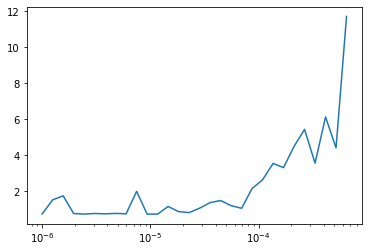

In [8]:
# Plot LR vs Loss
lrs = []
losses = []
with open("/projects/rsna-breast-cancer-detection/lrfinder.txt", 'r') as reader:
    for line in reader.readlines()[0:30]:
        loss, lr = line.replace("\n", "").split(" ")
        losses.append(float(loss))
        lrs.append(float(lr))

import matplotlib.pyplot as plt
plt.plot(lrs, losses)
plt.ticklabel_format(style='sci', axis='x')
plt.xscale('log')
plt.show()
